In [2]:
# import packages
%matplotlib nbagg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.widgets
import seaborn as sns

from tkinter import * 
import tkinter.messagebox 

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import RadioButtons
from sklearn import svm
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)


In [3]:
class Preprocessor:
    def __init__ (self, data):
        self.data = data

    def encode(self, kind: str, c_name):

        # update self.data with the appropriate encoder
        assert kind in ['onehot', 'label']
        self.kind = kind
          
        # do one hot encoder
        if self.kind == 'onehot':
            classes = set(self.data[c_name])
            for cls in classes:
                self.data[cls] = self.data[c_name].apply(lambda x: 1 if x == cls else 0)
            del self.data[c_name]
            return self.data
            
        # do label encoder
        else:
            classes = set(self.data[c_name])
            values = {list(classes)[i]: i for i in range(len(classes))}
            self.data[c_name] = self.data[c_name].apply(lambda x: values[x])

        return self.data
    
    def scaler(self, kind: str, c_name):
        
        # update self.data with the appropriate scaler
        
         # make sure kind is either minmax or standard
        assert kind in ['minmax', 'standard']

        # start with minmax
        if kind == 'minmax':
            min_value = min(self.data[c_name])
            max_value = max(self.data[c_name])
            diff = max_value - min_value
            self.data[c_name] = self.data[c_name].apply(lambda x: (x - min_value) / diff)
            
            return self.data
        
        # then do standard scaler
        else:
            mean = self.data[c_name].mean()
            std = self.data[c_name].std()
            self.data[c_name] = self.data[c_name].apply(lambda x: (x - mean) / std)
            
        return self.data

    def remove (self, c_name):
        del self.data[c_name]
        return self.data
            
    def replace (self, c_name, kind):
        assert kind in ['mean', 'median','drop']
        
        if kind == 'mean':
            mean_value = self.data[c_name].mean()
            self.data[c_name] = self.data[c_name].fillna(mean_value)
            return self.data
        
        if kind == 'median':
            median_value = self.data[c_name].median()
            self.data[c_name] = self.data[c_name].fillna(median_value)
            return self.data
            
        else:
            self.data = self.data.dropna().reset_index(drop = True)
            return self.data

In [4]:
class preplotter:
    
    def __init__ (self, data):
        self.data = data
        
    # Function to plot linear 2D or 3D graph takes in column names and output graphs
        
    # func to plots scatter graphs 
    # for these functions column names are input, hence by setting the z name to 0 and checking it is not a string
    # we can seperate 3D plots from 2D plots
    
    # for all the functions below, they follow a similar manner
    # get fig ax objects
    # label axis
    # plot graph 
    
    def scatter(self, x_name, y_name, z_name = 0 ):
        if z_name == 0:
            fig, ax = plt.subplots()
            
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            
            ax.scatter(self.data[x_name], self.data[y_name], alpha=0.005)
            
        else:
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            ax.set_zlabel(z_name)
            
            ax.scatter(self.data[x_name], self.data[y_name], self.data[z_name])    
    
    # func to plot line graphs
    
    def line(self, x_name, y_name, z_name = 0):
        if z_name == 0:
            fig, ax = plt.subplots()
            
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            
            ax.plot(self.data[x_name], self.data[y_name])
            
        else:
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            ax.set_zlabel(z_name)
            
            ax.plot(self.data[x_name], self.data[y_name], self.data[z_name])
            
    # plot multiple line plots
    
    def multiline (self, x_list , y_list, z_list = 0):
        
        #hard set colours to be used, don't expect more than 8 values to be plotted at once
        colours = ('blue', 'green', 'orange', 'red', 'yellow' , 'purple', 'black', 'pink')

        if z_list == 0:

            fig, ax = plt.subplots()
            plt.subplots_adjust(left=0.45)

            lines = {}

            for i ,name in enumerate(x_list):

                if i == 0:
                    lines[name] = ax.plot( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.5)

                else:
                    lines[name] = ax.plot( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.025)

            # create radio box
            radio_ax = plt.axes( [0.0, 0.45, 0.3, 0.3],  facecolor='#ffffff')

            # create radio buttons
            radio = RadioButtons( radio_ax, x_list)

            # callback function to run when buttons are pressed
            def callback(label: str):
                for name, line in lines.items():
                    if name == label:
                        line[0].set_alpha(0.5)
                    else:
                        line[0].set_alpha(0.025)
                plt.draw()
                return

            # connect function to radio object and show
            radio.on_clicked(callback)

            plt.show()

            return radio


        else:
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            for i in range(len(x_list)):
                ax.plot( self.data[x_list[i]], self.data[y_list[i]], self.data[z_list[i]], label= x_list[i], alpha = 0.5)
                plt.legend()


    #plot multiple scatter plots
    def multiscatter (self, x_list , y_list, z_list = 0):

        colours = ('blue', 'green', 'orange', 'red', 'yellow' , 'purple', 'black', 'pink')

        if z_list == 0:

            fig, ax = plt.subplots()
            plt.subplots_adjust(left=0.45)

            lines = {}

            for i ,name in enumerate(x_list):

                if i == 0:
                    lines[name] = ax.scatter( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.5)

                else:
                    lines[name] = ax.scatter( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.025)

            # create radio box
            radio_ax = plt.axes( [0.0, 0.45, 0.3, 0.3],  facecolor='#ffffff')

            # create radio buttons
            radio = RadioButtons( radio_ax, x_list)

            # callback function to run when buttons are pressed
            def callback(label: str):
                for name, line in lines.items():
                    if name == label:
                        line.set_alpha(0.5)
                    else:
                        line.set_alpha(0.025)
                plt.draw()
                return

            # connect function to radio object and show
            radio.on_clicked(callback)

            plt.show()

            return radio


        else:
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            for i in range(len(x_list)):
                ax.scatter( self.data[x_list[i]], self.data[y_list[i]], self.data[z_list[i]], label= x_list[i], alpha = 0.5)
                plt.legend()

    def histogram (self, x_list):

        fig, ax = plt.subplots()
        bins = [0 ,1]

        inter = data[data[x_list] == 1]
        strokes = len(inter[inter['stroke'] == 1])
        print(f' the number of strokes is {strokes}.')
        nstrokes = len(inter) - strokes
        print(f' the number of non-strokes is {nstrokes}.')
        score = [nstrokes, strokes]
        ax.bar(bins,score)
        p = (strokes/nstrokes)*100
        dv = p - percentage
        suum = int(nstrokes + strokes)

        print(f'the percentage {p}%.')
        print(f'deviation from popluation stroke % = {dv}.')

        return dv, suum


In [5]:
class postplotter:
    
    def __init__ (self, regressor, y_test, X_test):
        self.regressor = regressor
        self.y_test = y_test
        self.X_test = X_test
        
    # plots real values xy slope = 1 and predicted values variance from that

    def preplot (self, regressor, y_test, X_test):

        fig, ax = plt.subplots()
        ax.plot(y_test, y_test, 'r-', label='Real')
        ax.scatter(self.y_test, self.regressor.predict(self.X_test), label = 'prediction')
        ax.set_xlabel('Test Data')
        ax.set_ylabel('Predicted/Test Data')
        ax.legend(frameon=False)
        ax.set_title('Prediction graph')
        print(regressor.score(self.X_test, self.y_test))
        
    # plots confusion matrix and gives FR values
        
    def confmatrix (self, regressor, y_test, X_test):
    
        fig, ax = plt.subplots()
        array = np.zeros((2, 2))

        for i, correct_value in enumerate(self.y_test):
            predicted_value = int(abs(np.round(self.regressor.predict(self.X_test)[i])))
            array[predicted_value, correct_value] += 1

        # print dataframe represenation of array
        print(pd.DataFrame(array))

        # plot array as image
        im = ax.imshow(array, origin='lower', cmap='hot_r')

        # label axes
        ax.set_xlabel('Real Type')
        ax.set_ylabel('Predicted Type')

        # add colorbar
        plt.colorbar(im)
        
        #calculates F1, P and R values
        P = array[0,0]/(array[1,1]+array[0,1])
        R = array[0,0]/(array[1,1]+array[1,0])
        F1 = 2*P*R/(P+R)

        print(f'Presicion is:\n\n{P}\n')
        print(f'recall is:\n\n{R}\n')
        print(f'F-score is:\n\n{F1}\n')

In [6]:
def load(fname: str, cv: str) -> tuple:
    # basic spliter for now
    """Loads 2 column data from a CSV file with 2 columns, x and y"""

    # read data
    data = pd.read_csv(fname)
    y_column = 'stroke'
    # get training data
    #n_rows = int(len(data) * training_ratio)

    X_columns = list(data.columns)
    X_columns.remove(y_column)
    X = data[X_columns].to_numpy()
    y = data[y_column].to_numpy()

    # splitting calling the scikit split method of each cross validator
    for train_index, test_index in cv.split(X):
#         print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


    # reshape x to ensure it is 2D
    # fixme: already 2D?
#     X_train = X_train.reshape(-1, 1)
#     X_test = X_test.reshape(-1, 1)

    # return all
    return X, y, X_train, y_train, X_test, y_test

class Regressor:
    """Container for analysing different metrics for a single regression class"""
    def __init__(self, cls, fname: str, cv, cls_kwargs: dict = {}, cv_kwargs: dict = {} ):
        # construct regressor object
        self.regressor = cls(**cls_kwargs)
        self.cv = cv(**cv_kwargs)

        # use load function
        # where cv is a splitting class i.e kFold()
        self.X, self.y, self.X_train, self.y_train, self.X_test, self.y_test = load(fname, self.cv)

        # fit data
        self.regressor.fit(self.X_train, self.y_train)

        # get predicted data
        self.y_pred = self.regressor.predict(self.X_test)

    def metric(self, cls, **kwargs) -> float:
        """Takes a sklearn.metrics class and returns the score of the regressor object"""

        # use the metric class to get a score
        return cls(self.y_test, self.y_pred)


In [7]:
data = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
# initialise preporcessor class
preprocessor = Preprocessor(data.copy())

# known id is irrelavent to stroke chance
preprocessor.remove('id')
# there is enough data to justify dropping NaN values in bmi
preprocessor.replace('bmi','drop')
# there are only 2 people with other as a gender, as insensitive as this is, they can be dropped
preprocessor.encode('onehot','gender')
preprocessor.remove("Other")
# there are only 2 marriage options, no live in partners or polygamy smh
preprocessor.encode('label','ever_married')
preprocessor.encode('onehot','work_type')
# there are only 2 residencital types and one is obviously better than the other
preprocessor.encode('label','Residence_type')
# there are 4 smoking statuses, and the labeling hierarchy makes no sense
preprocessor.encode('onehot','smoking_status')
# unknown smoking data can be dropped
preprocessor.remove('Unknown')
# all other data is between 1 and 0 as such to keep all data compareable, we should use minmax scaling as it also keeps
# values within 1 and 0
preprocessor.scaler('minmax','age')
preprocessor.scaler('minmax','avg_glucose_level')
preprocessor.scaler('minmax','bmi')

#output data to another csv file
preprocessor.data.to_csv('data/preprocessed-healthcare-dataset-stroke-data.csv')

209
4700
4.446808510638298
['hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'Male', 'Female', 'Never_worked', 'children', 'Self-employed', 'Govt_job', 'Private', 'smokes', 'never smoked', 'formerly smoked']
['age', 'avg_glucose_level', 'bmi']
hypertension


<IPython.core.display.Javascript object>


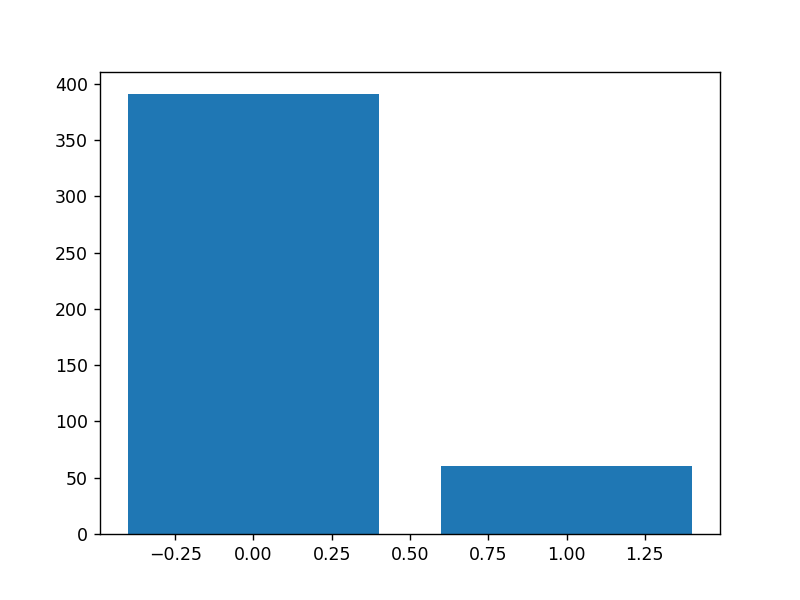

 the number of strokes is 60.
 the number of non-strokes is 391.
the percentage 15.34526854219949%.
deviation from popluation stroke % = 10.898460031561193.
---------------------------------------------------------------------------------------------------------
heart_disease


<IPython.core.display.Javascript object>


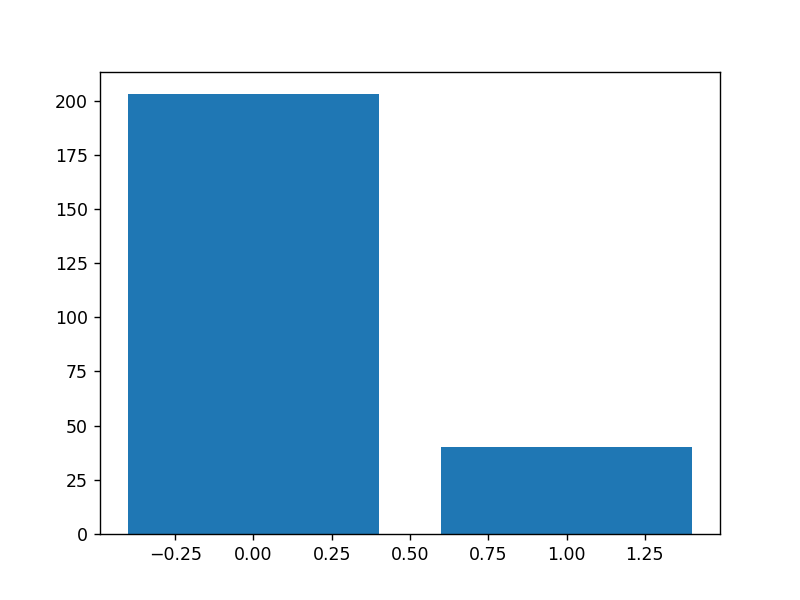

 the number of strokes is 40.
 the number of non-strokes is 203.
the percentage 19.704433497536947%.
deviation from popluation stroke % = 15.257624986898648.
---------------------------------------------------------------------------------------------------------
ever_married


<IPython.core.display.Javascript object>


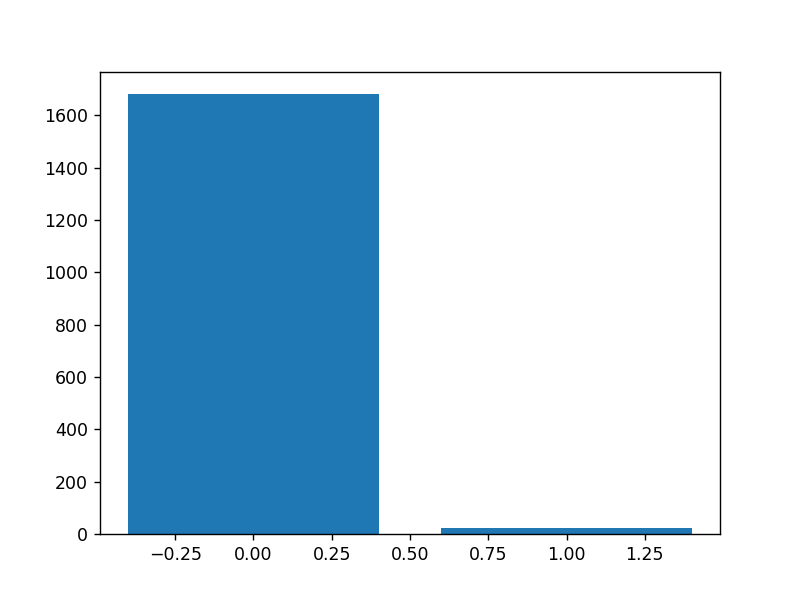

 the number of strokes is 23.
 the number of non-strokes is 1682.
the percentage 1.3674197384066586%.
deviation from popluation stroke % = -3.0793887722316393.
---------------------------------------------------------------------------------------------------------
Residence_type


<IPython.core.display.Javascript object>


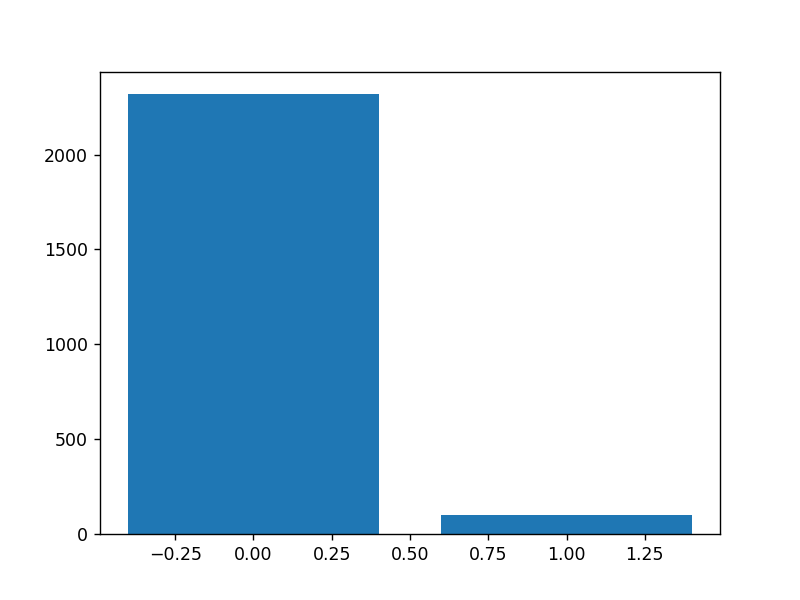

 the number of strokes is 100.
 the number of non-strokes is 2319.
the percentage 4.3122035360068995%.
deviation from popluation stroke % = -0.1346049746313982.
---------------------------------------------------------------------------------------------------------
Male


<IPython.core.display.Javascript object>


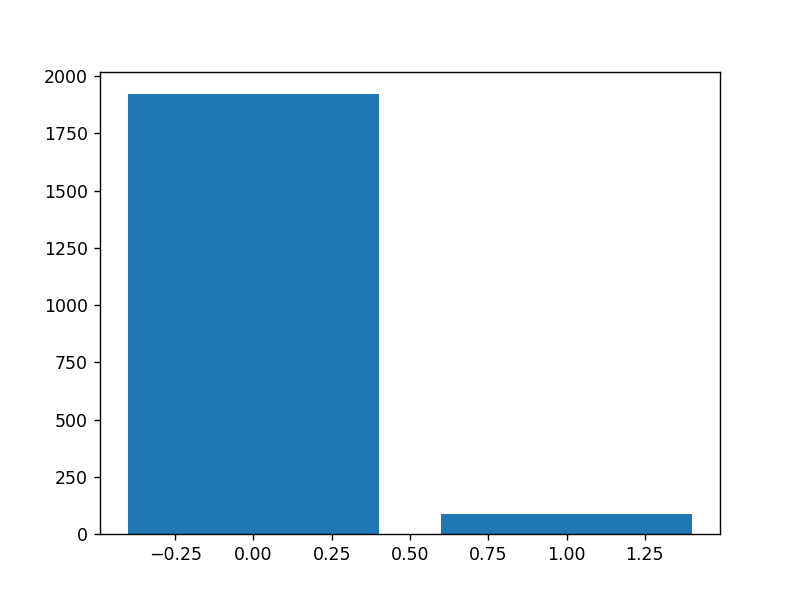

 the number of strokes is 89.
 the number of non-strokes is 1922.
the percentage 4.630593132154006%.
deviation from popluation stroke % = 0.1837846215157084.
---------------------------------------------------------------------------------------------------------
Female


<IPython.core.display.Javascript object>


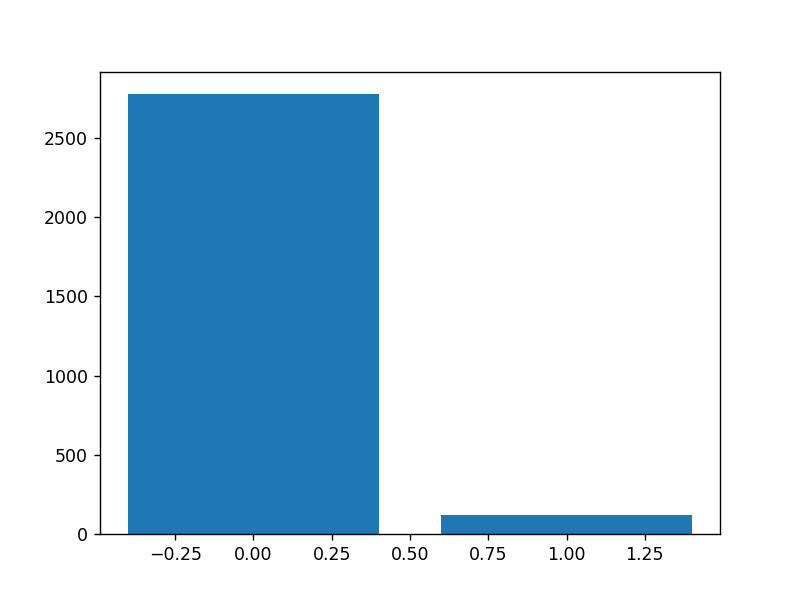

 the number of strokes is 120.
 the number of non-strokes is 2777.
the percentage 4.321209938782859%.
deviation from popluation stroke % = -0.12559857185543866.
---------------------------------------------------------------------------------------------------------
Never_worked


<IPython.core.display.Javascript object>


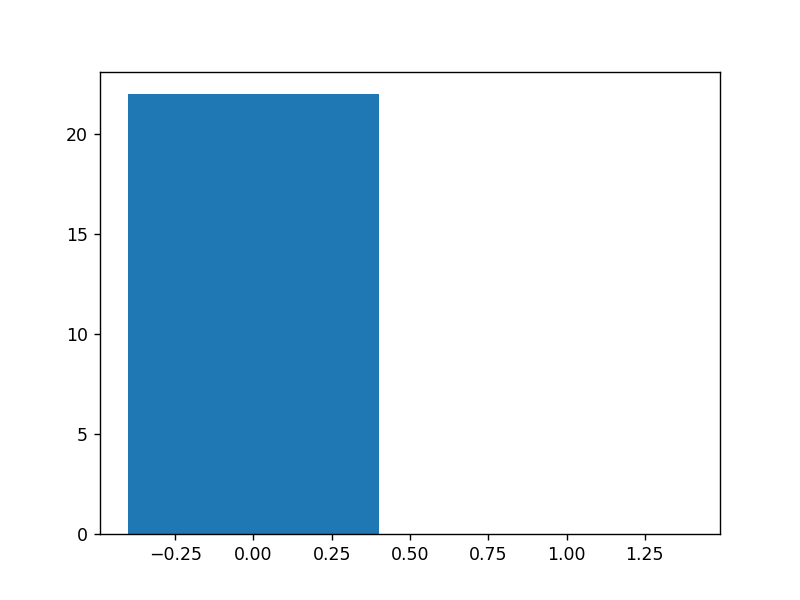

 the number of strokes is 0.
 the number of non-strokes is 22.
the percentage 0.0%.
deviation from popluation stroke % = -4.446808510638298.
---------------------------------------------------------------------------------------------------------
children


<IPython.core.display.Javascript object>


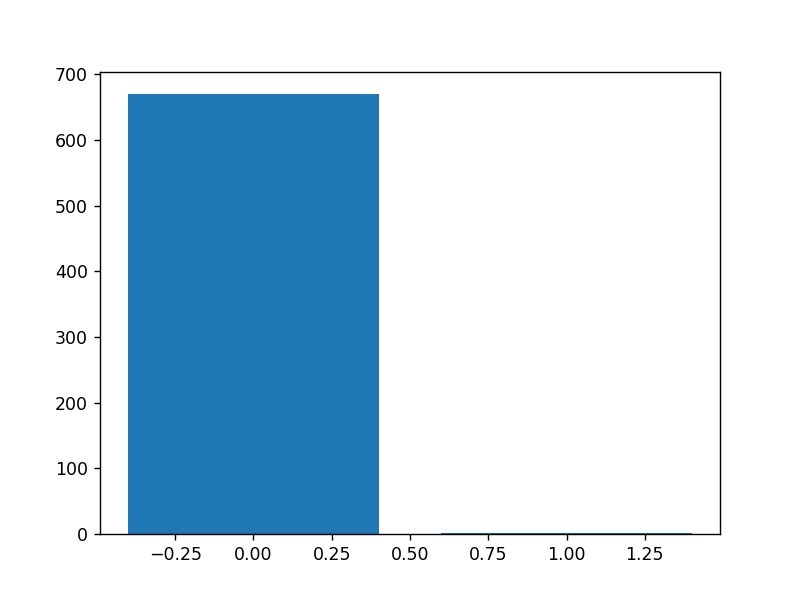

 the number of strokes is 1.
 the number of non-strokes is 670.
the percentage 0.1492537313432836%.
deviation from popluation stroke % = -4.297554779295014.
---------------------------------------------------------------------------------------------------------
Self-employed


<IPython.core.display.Javascript object>


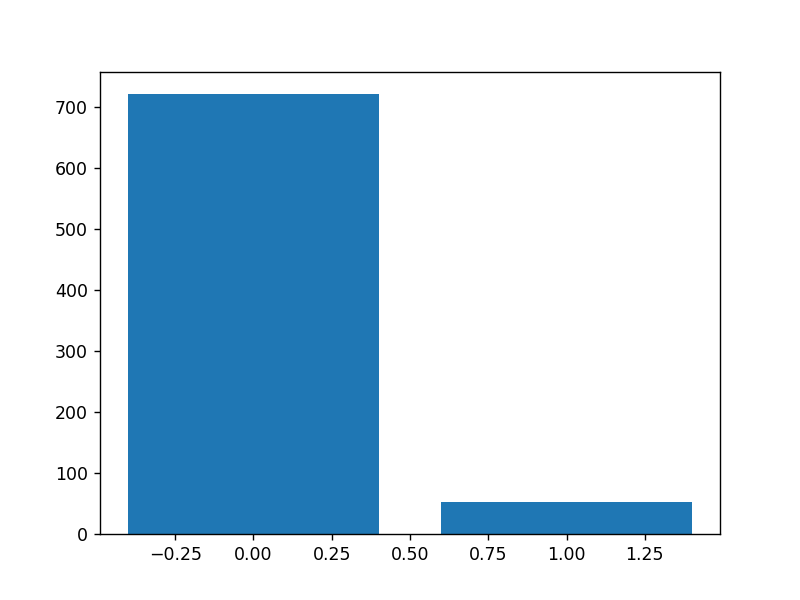

 the number of strokes is 53.
 the number of non-strokes is 722.
the percentage 7.340720221606649%.
deviation from popluation stroke % = 2.893911710968351.
---------------------------------------------------------------------------------------------------------
Govt_job


<IPython.core.display.Javascript object>


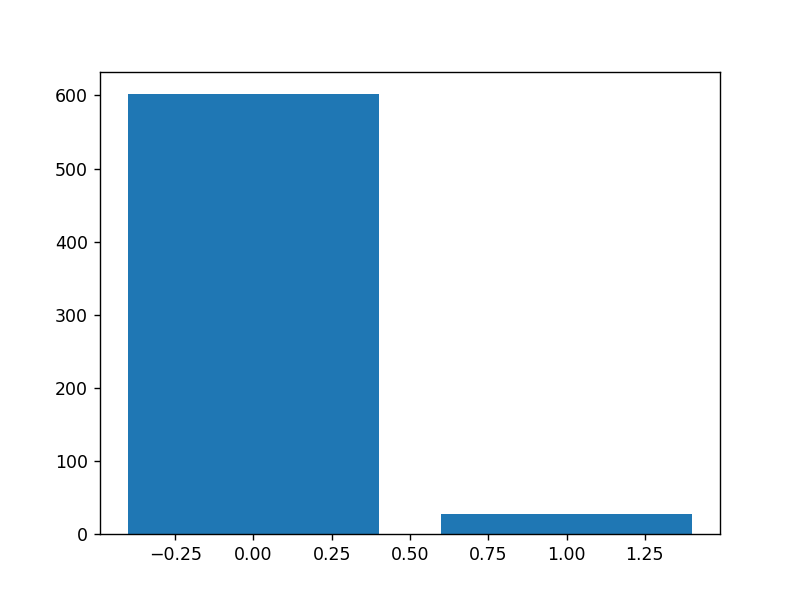

 the number of strokes is 28.
 the number of non-strokes is 602.
the percentage 4.651162790697675%.
deviation from popluation stroke % = 0.20435428005937695.
---------------------------------------------------------------------------------------------------------
Private


<IPython.core.display.Javascript object>


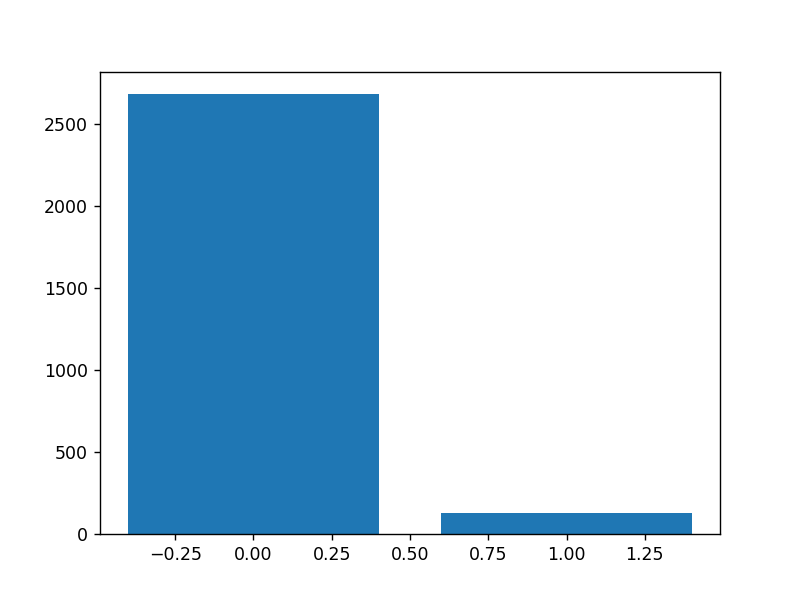

 the number of strokes is 127.
 the number of non-strokes is 2684.
the percentage 4.731743666169896%.
deviation from popluation stroke % = 0.2849351555315982.
---------------------------------------------------------------------------------------------------------
smokes


<IPython.core.display.Javascript object>


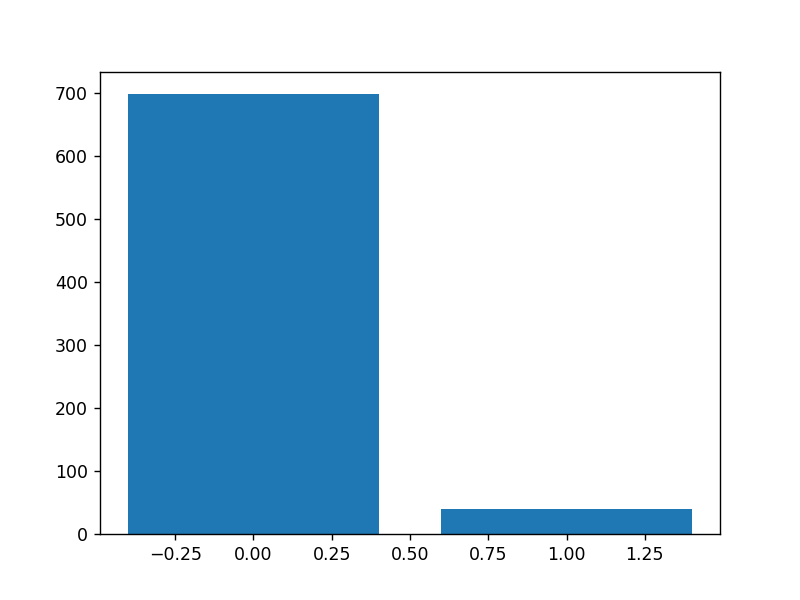

 the number of strokes is 39.
 the number of non-strokes is 698.
the percentage 5.587392550143266%.
deviation from popluation stroke % = 1.1405840395049687.
---------------------------------------------------------------------------------------------------------
never smoked


<IPython.core.display.Javascript object>


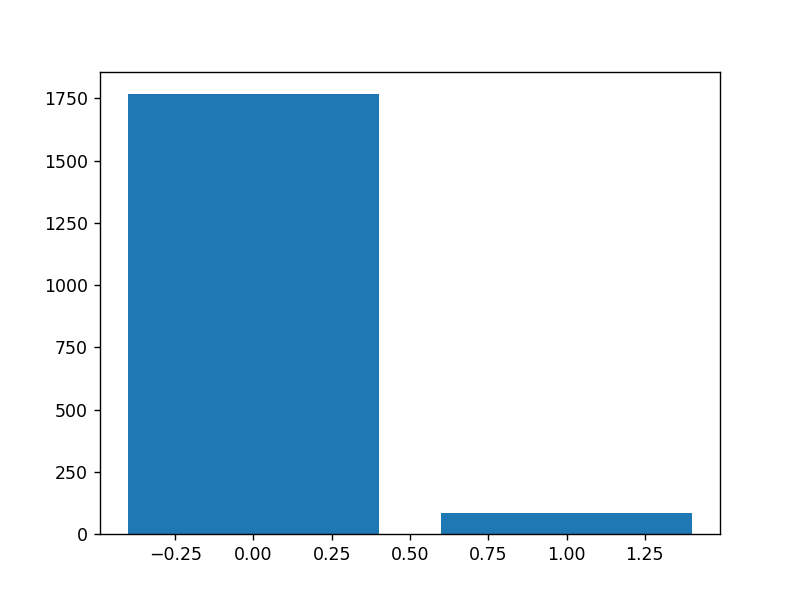

 the number of strokes is 84.
 the number of non-strokes is 1768.
the percentage 4.751131221719457%.
deviation from popluation stroke % = 0.30432271108115927.
---------------------------------------------------------------------------------------------------------
formerly smoked


<IPython.core.display.Javascript object>


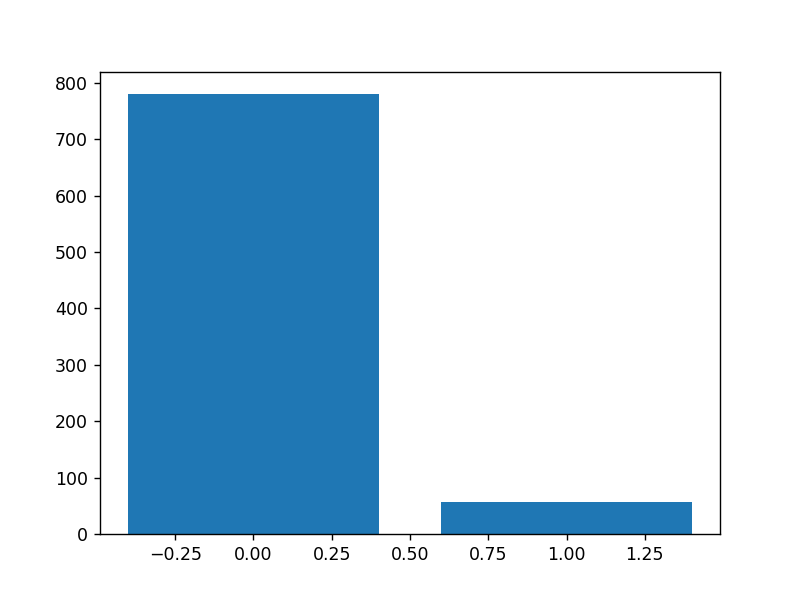

 the number of strokes is 57.
 the number of non-strokes is 780.
the percentage 7.307692307692308%.
deviation from popluation stroke % = 2.8608837970540106.
---------------------------------------------------------------------------------------------------------
['Residence_type', 'Male', 'Female', 'Never_worked', 'Govt_job', 'Private', 'smokes', 'never smoked']


In [11]:
data = pd.read_csv('data/preprocessed-healthcare-dataset-stroke-data.csv')

stroke_num = len(data[data['stroke'] == 1])
nstroke_num = len(data) - stroke_num

percentage = (stroke_num / nstroke_num) *100

print(stroke_num)
print(nstroke_num)
print(percentage)

bols = []
for key in data.columns:
    bols.append(key)

bols.remove('age')
bols.remove('avg_glucose_level')
bols.remove('bmi')
bols.remove('stroke')
bols.remove('Unnamed: 0')

nbols = ['age','avg_glucose_level','bmi']

print(bols)
print(nbols)

preplots = preplotter(data)
 
remove_list = []

for name in bols:
    print(name)
    dv, suum = preplots.histogram(name)
    print('---------------------------------------------------------------------------------------------------------')
    if abs(dv) < 2.5 or suum <150:
        remove_list. append(name)
print(remove_list)

data_p = Preprocessor(data.copy())

for name in remove_list:
    data_p.remove(name)
data_p.data.to_csv('data/preprocessed2-healthcare-dataset-stroke-data.csv')

In [27]:
from sklearn.ensemble import RandomForestRegressor
fname = 'data/preprocessed-healthcare-dataset-stroke-data.csv'
RFR = Regressor(RandomForestRegressor, fname, KFold)
RFR.y_pred
# preplot = preplotter(data)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.